In [260]:
import warnings 
warnings.filterwarnings("ignore")

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [261]:
%run ./analysis_utils/lang_comparer.py
%run ./analysis_utils/chunk_comparer.py

#### Utils

In [262]:
def merge_results(results, merge_on="chunk_bucket"):
    model_names = list(results.keys())
    model_dfs = list(results.values())
    merged = model_dfs[0]
    for i, (model_name, model_df) in enumerate(zip(model_names[1:], model_dfs[1:])):
        if merge_on == "chunk_bucket":
            model_df = model_df.drop(columns=["chunk_buckets", "count"])
        else:
            model_df = model_df.drop(columns=["count"])
        merged = merged.merge(model_df, on=merge_on, suffixes=("", f"_{model_name}"))
    return merged

### Lang Comparison

In [264]:
baseline_lang_comparer = LangComparer(model="baseline", test_path="../../data/test/merged_test_data.csv")
baseline_df = baseline_lang_comparer.run()

chunk_lang_comparer = LangComparer(model="chunk_combinations", test_path="../../data/test/merged_test_data.csv")
chunk_df = chunk_lang_comparer.run()

text_sum_lang_comparer = LangComparer(model="text_summarizer", test_path="../../data/test/merged_test_data.csv")
text_sum_df = text_sum_lang_comparer.run()

oai_sum_lang_comparer = LangComparer(model="oai_summarizer", test_path="../../data/test/merged_test_data.csv")
openai_sum_df = oai_sum_lang_comparer.run()

results = {
    "baseline": baseline_df,
    "chunk_combinations": chunk_df,
    "text_summarizer": text_sum_df,
    "oai_summarizer": openai_sum_df
}

merged_df = merge_results(results, merge_on="lang_pair")

5
5
5
5


In [265]:
merged_df["corr_diff_1_4_percentage"] = round((merged_df["mean_corr_chunk_combinations"] - merged_df["mean_corr"]) / merged_df["mean_corr"] * 100, 2)
merged_df["corr_diff_1_2_percentage"] = round((merged_df["mean_corr_text_summarizer"] - merged_df["mean_corr"]) / merged_df["mean_corr"] * 100, 2)
merged_df["corr_diff_1_5_percentage"] = round((merged_df["mean_corr_oai_summarizer"] - merged_df["mean_corr"]) / merged_df["mean_corr"] * 100, 2)

In [267]:
# drop corr_diff_1_4_percentage and corr_diff_1_2_percentage columns
#merged_df = merged_df.drop(columns=["corr_diff_1_4_percentage", "corr_diff_1_2_percentage"])
merged_df.head()

,count,mean_corr,mean_corr_chunk_combinations,mean_corr_text_summarizer,mean_corr_oai_summarizer,corr_diff_1_4_percentage,corr_diff_1_2_percentage,corr_diff_1_5_percentage
lang_pair,,,,,,,,
de_de,498,0.682,0.656,0.674,0.720,-3.81,-1.17,5.57
es_en,381,0.700,0.672,0.650,0.784,-4.00,-7.14,12.00
it_it,351,0.726,0.694,0.636,0.754,-4.41,-12.40,3.86
en_en,264,0.712,0.670,0.674,0.780,-5.90,-5.34,9.55
es_it,251,0.646,0.484,0.548,0.698,-25.08,-15.17,8.05


In [269]:
# get unique lang pairs
merged_df = merged_df.reset_index()
lang_pairs = merged_df["lang_pair"].unique()

train_df = pd.read_csv("../../data/train/train.csv")

train_df["lang_pair"] = train_df["lang1"] + "_" + train_df["lang2"]

for lang_pair in lang_pairs:
    if lang_pair not in train_df["lang_pair"].values:
        reverse_lang_pair = lang_pair.split("_")[1] + "_" + lang_pair.split("_")[0]
        if reverse_lang_pair not in train_df["lang_pair"].values:
            print(reverse_lang_pair, lang_pair)

    

it_it it_it
it_es es_it
ru_ru ru_ru
zh_zh zh_zh
fr_de de_fr
en_zh zh_en
pl_de de_pl
it_en en_it
zh_en en_zh
pl_fr fr_pl
ja_ja ja_ja
de_ru ru_de
en_ja ja_en


#### Lang Comparison: same language vs different language

In [270]:
unique_lang_pairs = merged_df.index.unique()
merged_df.reset_index(inplace=True)
def create_is_same_lang_column(row):
    lang1, lang2 = row["lang_pair"].split("_")
    return lang1 == lang2

merged_df["is_same_lang"] = merged_df.apply(create_is_same_lang_column, axis=1)
print(merged_df)
same_lang_df = merged_df[merged_df["is_same_lang"] == True]
diff_lang_df = merged_df[merged_df["is_same_lang"] == False]

# average corr_diff_1_4_percentage, corr_diff_1_2_percentage
same_lang_corr_diff_1_4_percentage = same_lang_df["corr_diff_1_4_percentage"].mean()
same_lang_corr_diff_1_2_percentage = same_lang_df["corr_diff_1_2_percentage"].mean()

diff_lang_corr_diff_1_4_percentage = diff_lang_df["corr_diff_1_4_percentage"].mean()
diff_lang_corr_diff_1_2_percentage = diff_lang_df["corr_diff_1_2_percentage"].mean()

print(f"Same lang corr_diff_1_4_percentage: {same_lang_corr_diff_1_4_percentage}")
print(f"Same lang corr_diff_1_2_percentage: {same_lang_corr_diff_1_2_percentage}")
print(f"Diff lang corr_diff_1_4_percentage: {diff_lang_corr_diff_1_4_percentage}")
print(f"Diff lang corr_diff_1_2_percentage: {diff_lang_corr_diff_1_2_percentage}")

    index lang_pair count  mean_corr  mean_corr_chunk_combinations  \
0       0     de_de   498      0.682                         0.656   
1       1     es_en   381      0.700                         0.672   
2       2     it_it   351      0.726                         0.694   
3       3     en_en   264      0.712                         0.670   
4       4     es_it   251      0.646                         0.484   
5       5     tr_tr   238      0.758                         0.700   
6       6     ru_ru   197      0.652                         0.570   
7       7     es_es   194      0.778                         0.712   
8       8     pl_pl   180      0.688                         0.622   
9       9     zh_zh   162      0.692                         0.674   
10     10     de_en   150      0.708                         0.682   
11     11     fr_fr    98      0.814                         0.798   
12     12     de_fr    84      0.288                         0.366   
13     13     ar_ar 

### Chunk Comparison

In [187]:
baseline_chunk_comparer = ChunkComparer(model="baseline", test_path="../../data/test/merged_test_data.csv")
baseline_chunk_df = baseline_chunk_comparer.run()

chunk_chunk_comparer = ChunkComparer(model="chunk_combinations", test_path="../../data/test/merged_test_data.csv")
chunk_chunk_df = chunk_chunk_comparer.run()

text_sum_chunk_comparer = ChunkComparer(model="text_summarizer", test_path="../../data/test/merged_test_data.csv")
text_sum_chunk_df = text_sum_chunk_comparer.run()

results = {
    "baseline": baseline_chunk_df,
    "chunk_combinations": chunk_chunk_df,
    "text_summarizer": text_sum_chunk_df
}

5
5
5


#### Plot Chunk Number (for 1. Baseline)

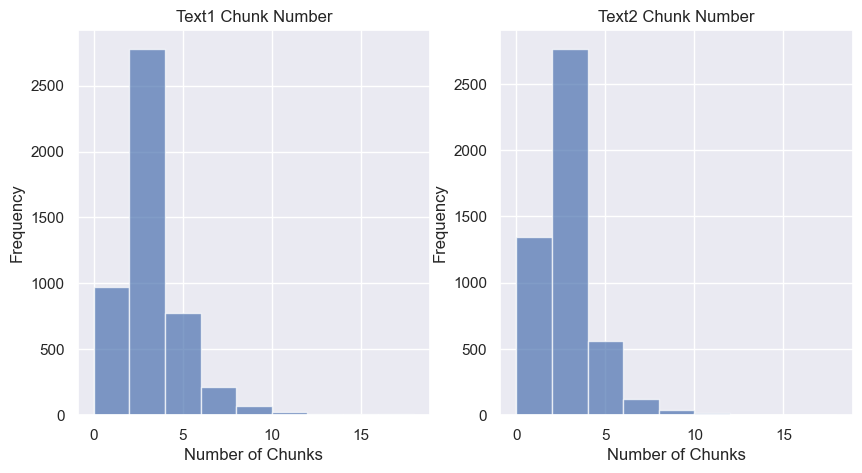

In [188]:
baseline_chunk_comparer.plot_chunk_num(baseline_chunk_comparer.test_df_with_chunk_num)

#### Plot Chunk Combination Number (for 3. Chunk Combinations)

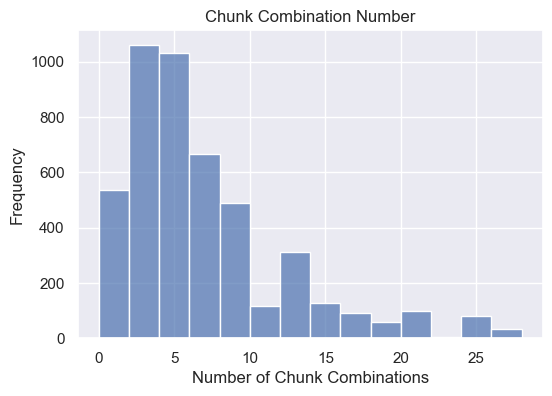

In [189]:
chunk_chunk_comparer.plot_chunk_combinations_num(chunk_chunk_comparer.test_df_with_chunk_num)

In [239]:
merged_df = merge_results(results, merge_on="chunk_bucket")
merged_df["corr_diff_1_4_percentage"] = round((merged_df["avg_corr_chunk_combinations"] - merged_df["avg_corr"]) / merged_df["avg_corr"] * 100, 2)
merged_df["corr_diff_1_2_percentage"] = round((merged_df["avg_corr_text_summarizer"] - merged_df["avg_corr"]) / merged_df["avg_corr"] * 100, 2)

merged_df = merged_df.sort_values(by="chunk_bucket")
merged_df

,count,chunk_buckets,avg_corr,avg_corr_chunk_combinations,avg_corr_text_summarizer,corr_diff_1_4_percentage,corr_diff_1_2_percentage
chunk_bucket,,,,,,,
2,1341,"(0, 2)",0.674,0.600,0.676,-10.98,0.30
4,1241,"(2, 4)",0.688,0.640,0.650,-6.98,-5.52
6,702,"(4, 6)",0.678,0.632,0.618,-6.78,-8.85
8,235,"(6, 8)",0.640,0.638,0.576,-0.31,-10.00
10,377,"(8, 10)",0.708,0.646,0.594,-8.76,-16.10
12,312,"(10, 12)",0.718,0.696,0.624,-3.06,-13.09
14,27,"(12, 14)",0.654,0.632,0.642,-3.36,-1.83
16,192,"(14, 16)",0.668,0.636,0.590,-4.79,-11.68
18,58,"(16, 18)",0.632,0.654,0.624,3.48,-1.27


In [191]:
# create a normalized_count column
merged_df["normalized_count"] = merged_df["count"] / merged_df["count"].sum()

Text(0.5, 1.0, 'Chunk Combinations: Average Pearson Correlation per number of chunk combinations')

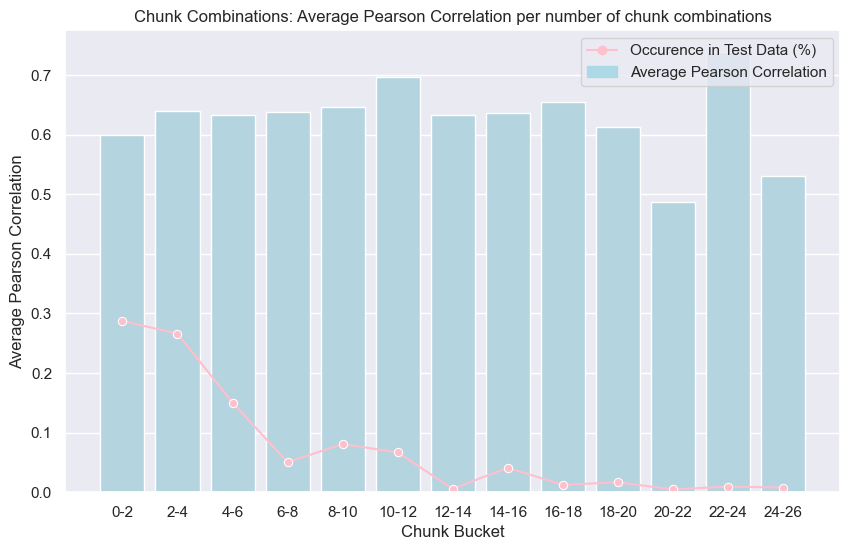

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

merged_df['chunk_buckets'] = merged_df['chunk_buckets'].astype(str)
merged_df['chunk_buckets'] = merged_df['chunk_buckets'].apply(lambda x: x.replace("(", "").replace(")", "").replace(", ", "-"))


sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 6))

#sns.barplot(x="chunk_bucket", y="avg_corr_chunk_combinations", data=merged_df, ax=ax, color="#CEEDE7", edgecolor="black")
sns.barplot(x="chunk_buckets", y="avg_corr_chunk_combinations", data=merged_df, ax=ax, color="lightblue")

#ax2 = ax.twinx()
sns.lineplot(x="chunk_buckets", y="normalized_count", data=merged_df, ax=ax, color="pink", marker="o")
ax.set_ylabel("Average Pearson Correlation")
ax.set_xlabel("Chunk Bucket")

# create a a legend to show the lineplot and barplot


line = mlines.Line2D([], [], color="pink", marker="o", label="Occurence in Test Data (%)")
bar = mpatches.Patch(color="lightblue", label="Average Pearson Correlation")
plt.legend(handles=[line, bar], loc="upper right")

plt.title("Chunk Combinations: Average Pearson Correlation per number of chunk combinations")

In [193]:
#check how many 

#### Average Distance

In [194]:
import pandas as pd

In [195]:
test_df = pd.read_csv("../../data/test/merged_test_data.csv")
test_df.head()

,pair_id,id1,text1,id2,text2,overall,lang1,lang2
0,1484189203_1484121193,1484189203,"DAVIE, FLA. (WSVN) - Police need help catching...",1484121193,"DEERFIELD BEACH, FLA. (WSVN) - A no-swim advis...",3.5,en,en
1,1484011097_1484011106,1484011097,Govt officials confirm Trump can block US comp...,1484011106,The latest huge unsecured cloud storage find i...,1.0,en,en
2,1484039488_1484261803,1484039488,"Ducks defenseman Erik Gudbranson, left, knocks...",1484261803,Woody Guthrie's 1943 New Year's Resolutions ar...,4.0,en,en
3,1484332324_1484796748,1484332324,The West Bengal government’s proposal was reje...,1484796748,Mumbai: The NCP and Shiv Sena on Thursday targ...,1.5,en,NaN
4,1484012256_1484419682,1484012256,The video will start in 8 CancelSign up to FRE...,1484419682,"Jacksonville, FL - I'm not sure how we'll look...",4.0,NaN,en


## Performance Based on Text Length

In [196]:
%run ./analysis_utils/log_retriever.py

In [271]:
test_df = pd.read_csv("../../data/test/merged_test_data.csv")

baseline_log_retriever = LogRetreiver(model="baseline", test_path="../../data/test/merged_test_data.csv")
_, baseline_pred_dfs = baseline_log_retriever.get_logs()

chunk_log_retriever = LogRetreiver(model="chunk_combinations", test_path="../../data/test/merged_test_data.csv")
_, chunk_pred_dfs = chunk_log_retriever.get_logs()

text_summarizer_log_retriever = LogRetreiver(model="text_summarizer", test_path="../../data/test/merged_test_data.csv")
_, text_summarizer_pred_dfs = text_summarizer_log_retriever.get_logs()

oai_summarizer_log_retriever = LogRetreiver(model="oai_summarizer", test_path="../../data/test/merged_test_data.csv")
_, oai_summarizer_pred_dfs = oai_summarizer_log_retriever.get_logs()

5
5
5
5


In [272]:
def merge_on_pair_id(pred_dfs, model="baseline"):
    full_df = pd.concat(pred_dfs)

    if model != "baseline":
        result_df = full_df.groupby('pair_id').agg({
            'overall': 'first',  # Just take the first occurrence of 'true' since it should be the same across
            'logits': 'mean'   # Calculate the average of 'pred' values
        }).reset_index()
    else:
        result_df = full_df.groupby('pair_id').agg({
            'true': 'first',  # Just take the first occurrence of 'true' since it should be the same across
            'pred': 'mean'   # Calculate the average of 'pred' values
        }).reset_index()

    # merge with test_df on pair_id
    result_df = result_df.merge(test_df, on="pair_id")

    # add a text_len column which is the length of the text1 + text2
    result_df["text_len"] = result_df["text1"].str.len() + result_df["text2"].str.len()

    text_len_bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    result_df["text_len_bins"] = pd.cut(result_df["text_len"], bins=text_len_bins)

    correlations = defaultdict(dict)
    for text_bin in text_len_bins:
        filtered_df = result_df[(result_df["text_len"] >= text_bin) & (result_df["text_len"] < text_bin + 1000)]
        if model != "chunk_combinations":
            corr = filtered_df['overall'].corr(filtered_df['pred'])
        else:
            filtered_df.rename(columns={'overall_x': 'overall'}, inplace=True)
            corr = filtered_df['overall'].corr(filtered_df['logits'])

        text_bin = int(text_bin / 1000)
        correlations[text_bin] = {"corr": f"{corr:.2f}", "count": len(filtered_df), "text_bucket": (text_bin, text_bin + 1)}

    # sort the dictionary by the correlation
    correlations = dict(sorted(correlations.items(), key=lambda item: item[1]["text_bucket"], reverse=False))

    #create a table of the correlations and counts
    correlations_df = pd.DataFrame(correlations).T
    correlations_df.index.name = 'text_bucket'

    correlations_df['text_bucket'] = correlations_df['text_bucket'].astype(str)
    correlations_df['text_bucket'] = correlations_df['text_bucket'].apply(lambda x: x.replace("(", "").replace(")", "").replace(", ", "-"))

    correlations_df["normalized_count"] = correlations_df["count"] / correlations_df["count"].sum()

    return correlations_df

In [273]:
baseline_result_df = merge_on_pair_id(baseline_pred_dfs)
oai_result_df = merge_on_pair_id(oai_summarizer_pred_dfs)
text_summarizer_result_df = merge_on_pair_id(text_summarizer_pred_dfs)

baseline_result_df

,corr,count,text_bucket,normalized_count
text_bucket,,,,
0,0.67,378,0-1,0.080034
1,0.72,861,1-2,0.182299
2,0.71,1054,2-3,0.223163
3,0.71,769,3-4,0.16282
4,0.71,557,4-5,0.117934
5,0.63,397,5-6,0.084057
6,0.69,302,6-7,0.063942
7,0.70,184,7-8,0.038958
8,0.72,105,8-9,0.022232


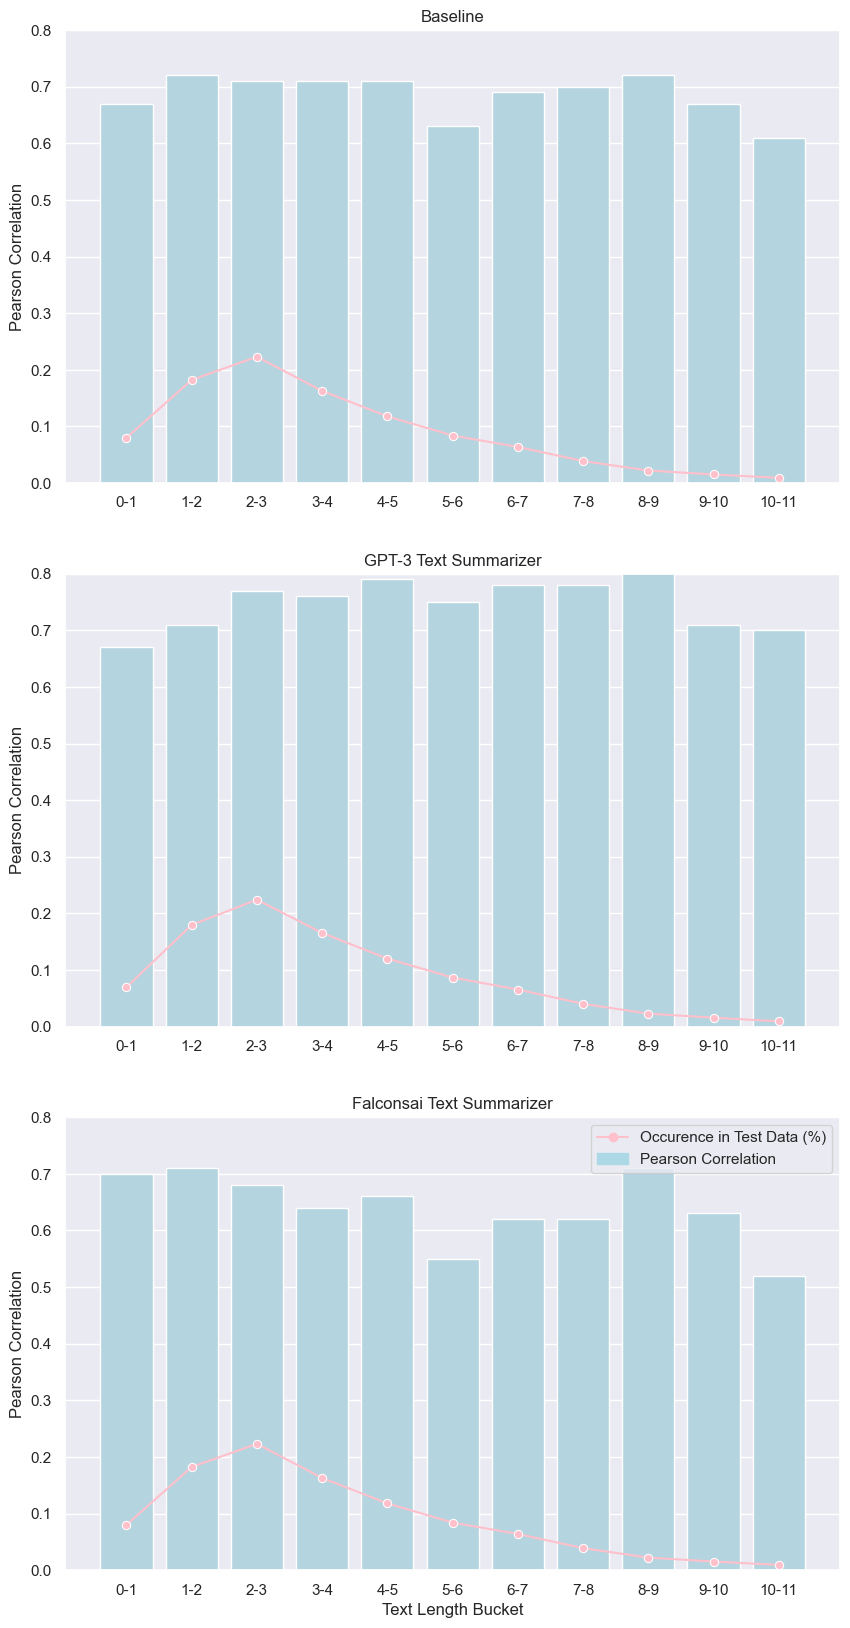

In [282]:
# plot performance per text length bucket
import matplotlib.pyplot as plt
import seaborn as sns

def plot_corr_per_text_bucket(result_df, model_name, ax=None, last=False):
    sns.set(style="darkgrid")
    #fig, ax = plt.subplots(figsize=(10, 6))

    # treat corr as float
    result_df["corr"] = result_df["corr"].astype(float)

    sns.barplot(x="text_bucket", y="corr", data=result_df, ax=ax, color="lightblue")

    sns.lineplot(x="text_bucket", y="normalized_count", data=result_df, ax=ax, color="pink", marker="o")

    ax.set_ylim(0, 0.8)
    ax.set_title(f"{model_name}")

    line = mlines.Line2D([], [], color="pink", marker="o", label="Occurence in Test Data (%)")
    bar = mpatches.Patch(color="lightblue", label="Pearson Correlation")
    plt.legend(handles=[line, bar], loc="upper right")

    ax.set_ylabel("Pearson Correlation")
    if last:
        ax.set_xlabel("Text Length Bucket")
    else:
        ax.set_xlabel("")
    #plt.title(f"{model_name}: Pearson Correlation per Text Length Bucket")


fig, ax = plt.subplots(3, 1, figsize=(10, 20))
plot_corr_per_text_bucket(baseline_result_df, "Baseline", ax=ax[0])
plot_corr_per_text_bucket(oai_result_df, "GPT-3 Text Summarizer", ax=ax[1])
plot_corr_per_text_bucket(text_summarizer_result_df, "Falconsai Text Summarizer", ax=ax[2], last=True)

### Performance: same language vs different language

In [235]:
def create_is_same_lang_column(row):
    lang1, lang2 = row["lang1"], row["lang2"]
    return lang1 == lang2

def merge_on_pair_id_for_lang(pred_dfs, model="baseline"):
    full_df = pd.concat(pred_dfs)

    if model != "baseline":
        result_df = full_df.groupby('pair_id').agg({
            'overall': 'first',  # Just take the first occurrence of 'true' since it should be the same across
            'logits': 'mean'   # Calculate the average of 'pred' values
        }).reset_index()
    else:
        result_df = full_df.groupby('pair_id').agg({
            'true': 'first',  # Just take the first occurrence of 'true' since it should be the same across
            'pred': 'mean'   # Calculate the average of 'pred' values
        }).reset_index()

    # merge with test_df on pair_id
    result_df = result_df.merge(test_df, on="pair_id")

    result_df["is_same_lang"] = result_df.apply(create_is_same_lang_column, axis=1)

    is_same_lang_df = result_df[result_df["is_same_lang"] == True]
    diff_lang_df = result_df[result_df["is_same_lang"] == False]

    if model != "chunk_combinations":
        same_corr = is_same_lang_df['overall'].corr(is_same_lang_df['pred'])
        diff_corr = diff_lang_df['overall'].corr(diff_lang_df['pred'])
    else:
        is_same_lang_df.rename(columns={'overall_x': 'overall'}, inplace=True)
        diff_lang_df.rename(columns={'overall_x': 'overall'}, inplace=True)
        same_corr = is_same_lang_df['overall'].corr(is_same_lang_df['logits'])
        diff_corr = diff_lang_df['overall'].corr(diff_lang_df['logits'])

    return same_corr, diff_corr


In [238]:
baseline_same_corr, baseline_diff_corr = merge_on_pair_id_for_lang(baseline_pred_dfs)
print(f"Baseline: Same lang corr: {baseline_same_corr}, Diff lang corr: {baseline_diff_corr}")

chunk_same_corr, chunk_diff_corr = merge_on_pair_id_for_lang(chunk_pred_dfs, model="chunk_combinations")
print(f"Chunk Combinations: Same lang corr: {chunk_same_corr}, Diff lang corr: {chunk_diff_corr}")

text_summarizer_same_corr, text_summarizer_diff_corr = merge_on_pair_id_for_lang(text_summarizer_pred_dfs)
print(f"Text Summarizer: Same lang corr: {text_summarizer_same_corr}, Diff lang corr: {text_summarizer_diff_corr}")

Baseline: Same lang corr: 0.7251370747110145, Diff lang corr: 0.685508046518105
Chunk Combinations: Same lang corr: 0.6995544948361038, Diff lang corr: 0.6465369770467629
Text Summarizer: Same lang corr: 0.6842781955918349, Diff lang corr: 0.6488196978046546


In [286]:
# find text pairs that have more than 4000 words in total (text1 + text2)
def create_text_len_column(row):
    len_text1 = " ".join(row["text1"]).split(" ")
    len_text2 = " ".join(row["text2"]).split(" ")

    return len(len_text1) + len(len_text2)

test_df["text_len"] = test_df.apply(create_text_len_column, axis=1)

In [289]:
less_than_5000 = test_df[test_df["text_len"] > 5000]
less_than_4000 = test_df[test_df["text_len"] > 4000]

ratio_5000 = len(less_than_5000) / len(test_df)
ratio_4000 = len(less_than_4000) / len(test_df)

print(f"Ratio of text pairs with more than 5000 words: {ratio_5000}")
print(f"Ratio of text pairs with more than 4000 words: {ratio_4000}")

Ratio of text pairs with more than 5000 words: 0.3234932349323493
Ratio of text pairs with more than 4000 words: 0.44587945879458796


In [291]:
test_df.head()

,pair_id,id1,text1,id2,text2,overall,lang1,lang2,text_len
0,1484189203_1484121193,1484189203,"DAVIE, FLA. (WSVN) - Police need help catching...",1484121193,"DEERFIELD BEACH, FLA. (WSVN) - A no-swim advis...",3.5,en,en,947
1,1484011097_1484011106,1484011097,Govt officials confirm Trump can block US comp...,1484011106,The latest huge unsecured cloud storage find i...,1.0,en,en,11748
2,1484039488_1484261803,1484039488,"Ducks defenseman Erik Gudbranson, left, knocks...",1484261803,Woody Guthrie's 1943 New Year's Resolutions ar...,4.0,en,en,12283
3,1484332324_1484796748,1484332324,The West Bengal government’s proposal was reje...,1484796748,Mumbai: The NCP and Shiv Sena on Thursday targ...,1.5,en,NaN,6338
4,1484012256_1484419682,1484012256,The video will start in 8 CancelSign up to FRE...,1484419682,"Jacksonville, FL - I'm not sure how we'll look...",4.0,NaN,en,17829
